# Adversarial attacks and robustness for QML (FGSM)
- https://pennylane.ai/qml/demos/tutorial_adversarial_attacks_QML
- https://adversarial-ml-tutorial.org/adversarial_examples/

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

import skimage

## Datatset and visualization

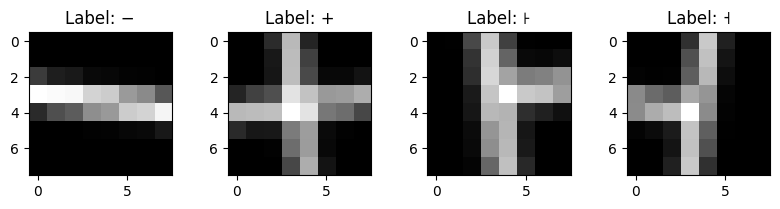

In [2]:
# we can use the dataset hosted on PennyLane
[pm] = qml.data.load('other', name='plus-minus')

X_train_orig = pm.img_train  # shape (1000,16,16)
X_test_orig = pm.img_test  # shape (200,16,16)
Y_train = pm.labels_train  # shape (1000,)
Y_test = pm.labels_test  # shape (200,)

X_train = np.transpose(X_train_orig, (1, 2, 0)) # put height and width in front
X_train = skimage.transform.resize(X_train, (8, 8)) 
X_train = np.transpose(X_train, (2, 0, 1) ) # move back 

X_test = np.transpose(X_test_orig, (1, 2, 0)) # put height and width in front
X_test = skimage.transform.resize(X_test, (8, 8)) 
X_test = np.transpose(X_test, (2, 0, 1) ) # move back 

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [
    (X_train[Y_train == 0])[0],
    (X_train[Y_train == 1])[0],
    (X_train[Y_train == 2])[0],
    (X_train[Y_train == 3])[0],
]
y_vis = [0, 1, 2, 3]


# later when we train the model we include the predictions as well, so let's just add the functionality here
def visualize_data(x, y, pred=None):
    n_img = len(x)
    labels_list = ["\u2212", "\u002b", "\ua714", "\u02e7"]
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(labels_list[y[i]]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
    plt.tight_layout(w_pad=2)
    # plt.show()


visualize_data(x_vis, y_vis)

## QML classification

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeLimaV2

# use device with 5 qubits
fake_backend = FakeLimaV2()

# passing a string in backend would result in an error
fake_dev = qml.device('qiskit.remote', wires=5, backend=fake_backend)

In [4]:
# build circuit
#### Hyperparameters ####
input_dim = 8*8 #16*16
num_classes = 4
num_layers = 16
num_qubits = 4
num_reup = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        #self.device = qml.device("default.mixed", wires=self.num_qubits)
        self.device = fake_dev
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )

            # The noise is added here:
            #for wire in range(self.num_qubits):
            #    qml.DepolarizingChannel(0.01, wires=wire)
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cpu


In [5]:
# train classifier
#### Hyperparameters ####
learning_rate = 0.1
epochs = 4
batch_size = 20

# we use a subset of the training and validation data for this tutorial to speed up the training
feats_train = torch.from_numpy(X_train[:200]).reshape(200, -1).to(device)
feats_test = torch.from_numpy(X_test[:50]).reshape(50, -1).to(device)
labels_train = torch.from_numpy(Y_train[:200]).to(device)
labels_test = torch.from_numpy(Y_test[:50]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

Starting training loop for quantum variational classifier (4 qubits, 16 layers)...
Epoch 0/4 | Approx Cost (train): 1.3879536 | Cost (val): 1.3863484 | Approx Acc train: 0.2600000 | Acc val: 0.3000000
Epoch 1/4 | Approx Cost (train): 1.3797356 | Cost (val): 1.3892993 | Approx Acc train: 0.3000000 | Acc val: 0.2600000
Epoch 2/4 | Approx Cost (train): 1.3631421 | Cost (val): 1.3716567 | Approx Acc train: 0.2800000 | Acc val: 0.2800000
Epoch 3/4 | Approx Cost (train): 1.3703961 | Cost (val): 1.3345431 | Approx Acc train: 0.2200000 | Acc val: 0.4200000
Epoch 4/4 | Approx Cost (train): 1.3529711 | Cost (val): 1.3310639 | Approx Acc train: 0.3200000 | Acc val: 0.5200000


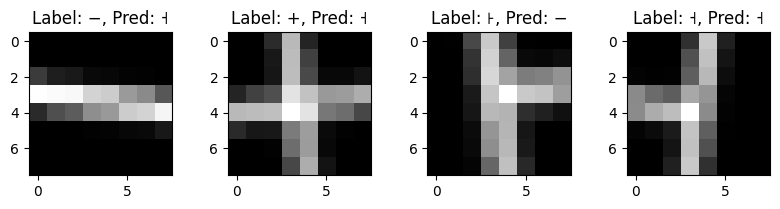

In [6]:
# evaluate benign data
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(4, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualize_data(x_vis, y_vis, benign_class_output)

## get some values of our training

In [7]:
# accuracy
predictions_test = [qml_model(f) for f in feats_test]
acc_approx_test = accuracy(labels_test, predictions_test)
print(f"Acc val: {acc_approx_test:0.7f}")

Acc val: 0.4000000


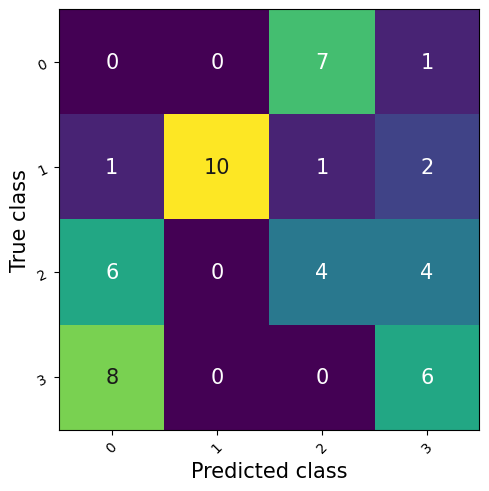

In [8]:
# confusion matrix on test set
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=4)

#print(labels_test)
preds_max = [torch.argmax(predictions_test[i]).detach().numpy().item() for i in range(len(predictions_test))]
#print(preds_max)
#print(torch.tensor(preds_max))

metric.update(torch.tensor(preds_max), labels_test)

fig_, ax_ = metric.plot()

## now attack

In [9]:
# create FGSM
# simple implementation of fast gradient sign method (FGSM) attack
# for an introduction to FGSM, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def FGSM(model, feats, labels, epsilon=0.1):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    
    feats_adv = feats + delta
    outputs = [model(f) for f in feats_adv]

    # forward & backward pass through the model, accumulating gradients
    l = loss(torch.stack(outputs), labels)
    l.backward()
    return epsilon*delta.grad.detach().sign()

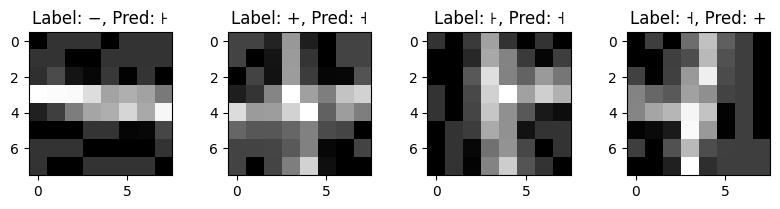

In [10]:
# evaluate - model under attack
perturbations = FGSM(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 8, 8), y_vis, adversarial_class_output)

## get some values of robustness after attack

In [11]:
# accuracy
perturbation_test = FGSM(model=qml_model, feats=feats_test, labels=labels_test, epsilon=0.1)
perturbed_x_test = feats_test + perturbation_test

adversarial_preds_test = [qml_model(f) for f in perturbed_x_test]
acc_approx_test = accuracy(labels_test, adversarial_preds_test)
print(f"Acc val: {acc_approx_test:0.7f}")

Acc val: 0.2600000


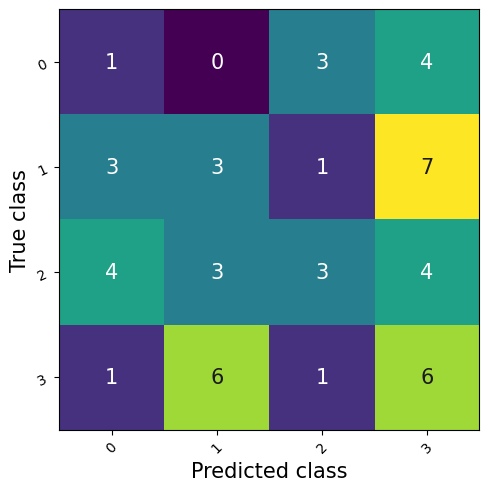

In [12]:
# confusion matrix on test set
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=4)

#print(labels_test)
preds_max = [torch.argmax(adversarial_preds_test[i]).detach().numpy().item() for i in range(len(adversarial_preds_test))]
#print(preds_max)
#print(torch.tensor(preds_max))

metric.update(torch.tensor(preds_max), labels_test)

fig_, ax_ = metric.plot()

## increase robustness of model

In [13]:
# new training
adv_dataset = (
    FGSM(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

Epoch 0/2 | Approx Cost (train): 1.3658965 | Cost (val): 1.3349464 | Approx Acc train: 0.3600000 | Acc val: 0.5600000
Epoch 1/2 | Approx Cost (train): 1.3563021 | Cost (val): 1.3250111 | Approx Acc train: 0.3200000 | Acc val: 0.4800000
Epoch 2/2 | Approx Cost (train): 1.3448318 | Cost (val): 1.3468490 | Approx Acc train: 0.4200000 | Acc val: 0.4600000


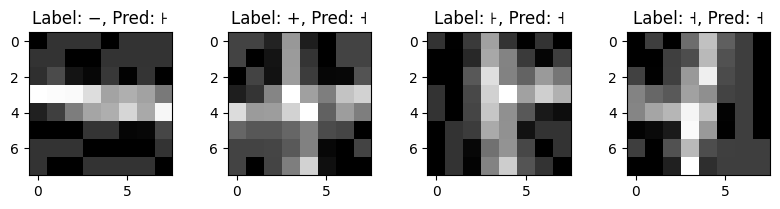

In [14]:
# evaluate - robustness
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 8, 8), y_vis, adversarial_class_output)

## get some values of robustness increasing robustness

In [15]:
# accuracy
# use pertubation_test and perturbation_x_test from attack and see its robutsness in new/updated model
#perturbation_test = PGD(model=qml_model, feats=feats_test, labels=labels_test, epsilon=0.1)
#perturbed_x_test = feats_test + perturbation_test

adversarial_preds_test_increased = [qml_model(f) for f in perturbed_x_test]
acc_approx_test = accuracy(labels_test, adversarial_preds_test_increased)
print(f"Acc val: {acc_approx_test:0.7f}")

Acc val: 0.4200000


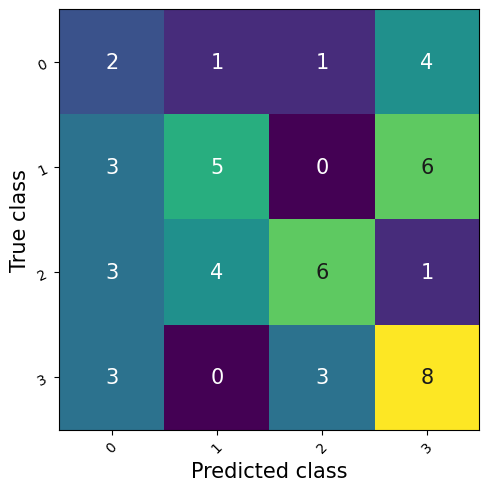

In [16]:
# confusion matrix on test set
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=4)

#print(labels_test)
preds_max = [torch.argmax(adversarial_preds_test_increased[i]).detach().numpy().item() for i in range(len(adversarial_preds_test_increased))]
#print(preds_max)
#print(torch.tensor(preds_max))

metric.update(torch.tensor(preds_max), labels_test)

fig_, ax_ = metric.plot()